# **10 Monkey Species Classification using Convolutional Neural Networks in PyTorch** #

In [60]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm
%matplotlib inline

In [61]:
DATA_DIR = '../input/10-monkey-species'

TRAIN_DIR = DATA_DIR + '/training/training'                           # Contains training images  
VAL_DIR = DATA_DIR + '/validation/validation'
TEST_DIR='../input/testing-dataset-for-10-species-of-monkey/testing'

In [109]:
labels_name= ['mantled_howler',
              'patas_monkey',
            'bald_uakari',
            'japanese_macaque',
            'pygmy_marmoset',
            'white_headed_capuchin',
            'silvery_marmoset',
            'common_squirrel_monkey',
            'black_headed_night_monkey',
            'nilgiri_langur']

In [63]:
labels_name['n0']

'mantled_howler'

In [64]:
transform = transforms.Compose ([ transforms.Resize(size=(256,256) , interpolation=2),transforms.ToTensor(),])

In [65]:
train_dataset = ImageFolder ( TRAIN_DIR , transform=transform )
val_dataset = ImageFolder ( VAL_DIR , transform=transform ) 
test_dataset= ImageFolder ( TEST_DIR , transform=transform ) 

In [66]:
len(train_dataset)

1097

In [67]:
len(test_dataset)

100

In [68]:
len(val_dataset)

272

In [69]:
print(train_dataset.classes)

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


In [70]:
train_dataset[576]

(tensor([[[0.1098, 0.1373, 0.1922,  ..., 0.4510, 0.4588, 0.4667],
          [0.0980, 0.1412, 0.1804,  ..., 0.4588, 0.4510, 0.4627],
          [0.1333, 0.1176, 0.1843,  ..., 0.4667, 0.4627, 0.4667],
          ...,
          [0.1255, 0.0549, 0.0118,  ..., 0.3059, 0.3725, 0.4863],
          [0.1529, 0.0706, 0.0118,  ..., 0.3020, 0.3608, 0.4196],
          [0.1882, 0.0863, 0.0235,  ..., 0.2745, 0.3412, 0.4275]],
 
         [[0.1882, 0.2275, 0.2941,  ..., 0.5490, 0.5569, 0.5686],
          [0.1765, 0.2314, 0.2863,  ..., 0.5529, 0.5529, 0.5647],
          [0.2078, 0.2039, 0.2902,  ..., 0.5569, 0.5608, 0.5686],
          ...,
          [0.2706, 0.2235, 0.2157,  ..., 0.2941, 0.2549, 0.3333],
          [0.2902, 0.2275, 0.2078,  ..., 0.2863, 0.2431, 0.2745],
          [0.3137, 0.2392, 0.2118,  ..., 0.2627, 0.2275, 0.2863]],
 
         [[0.0784, 0.1020, 0.1490,  ..., 0.1922, 0.1961, 0.1961],
          [0.0627, 0.1020, 0.1373,  ..., 0.2000, 0.1843, 0.1843],
          [0.0980, 0.0784, 0.1373,  ...,

In [71]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  n0 (0)


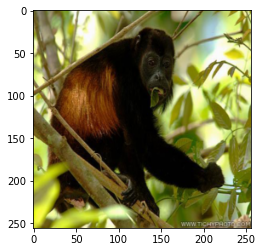

In [72]:
show_example(*train_dataset[0])

Label:  n0 (0)


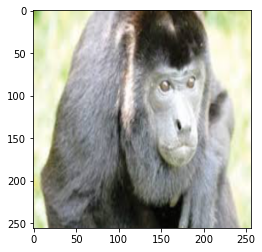

In [73]:
show_example(*test_dataset[0])

In [74]:
random_seed = 10
torch.manual_seed(random_seed);

In [75]:
batch_size=32

In [76]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size, num_workers=4, pin_memory=True)

images.shape: torch.Size([32, 3, 256, 256])


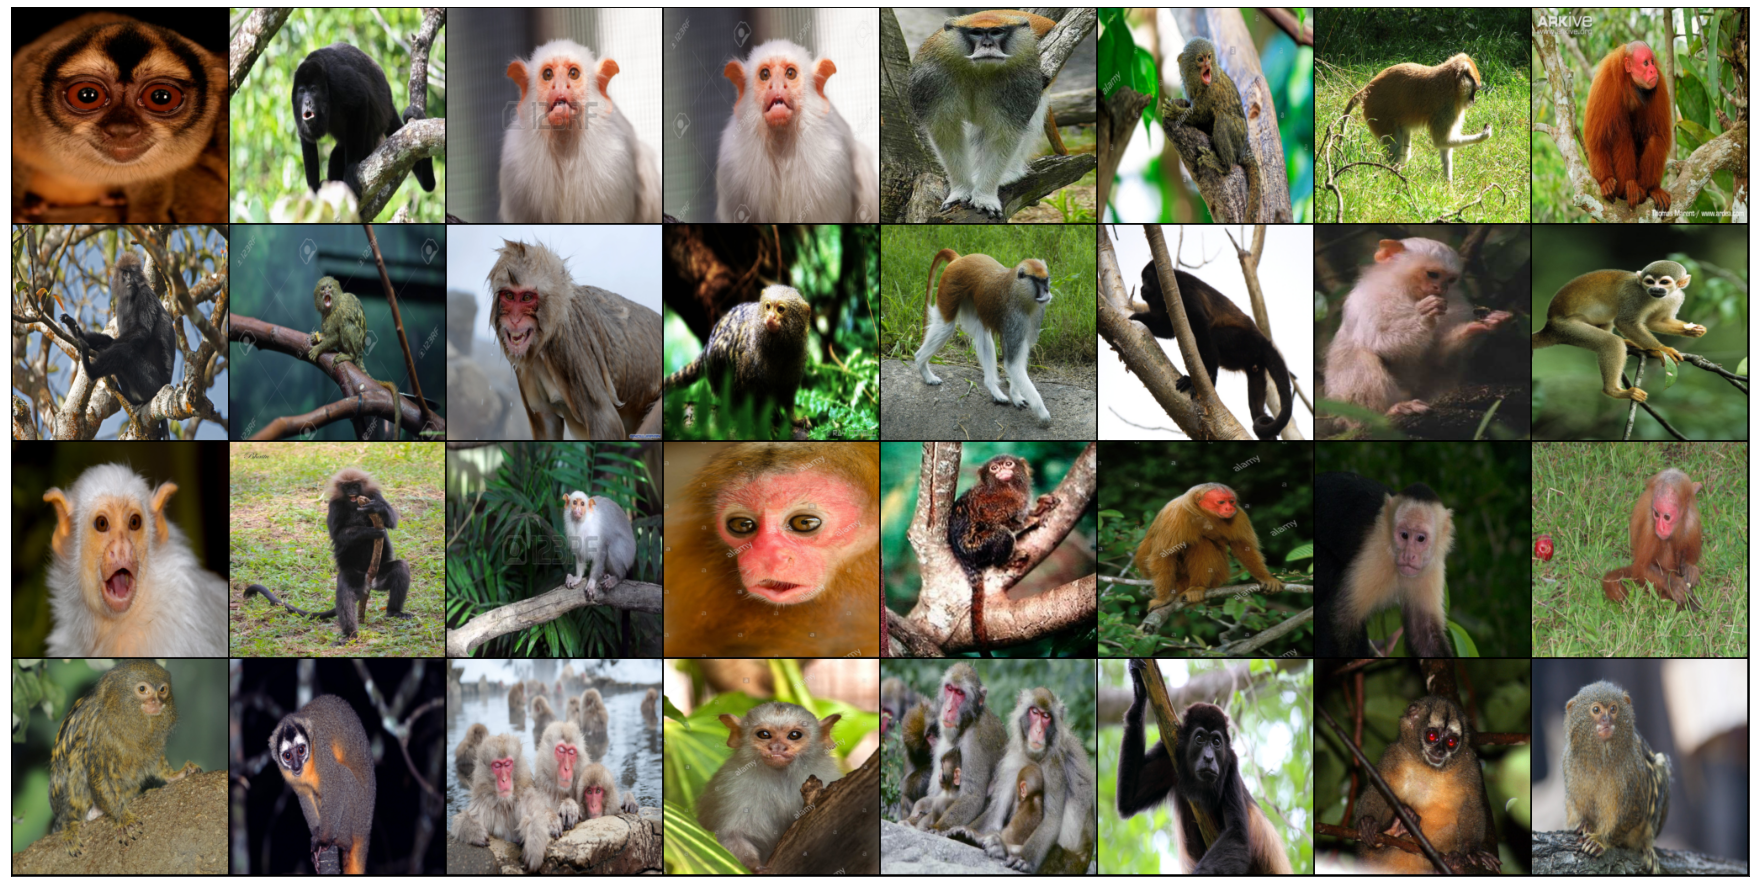

In [77]:
for images,labels in train_loader:
    print('images.shape:', images.shape)
    fig, ax = plt.subplots(figsize=(32, 16))
    plt.axis('on')
    ax.set_xticks([]); ax.set_yticks([])
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [78]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class MonkeyClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [79]:
class MonkeyCnnModel(MonkeyClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
             nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 32 x 128 x 128
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
             nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 64 x 64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
             nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 64 x 32 x 32
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # output: 128 x 16 x 16

            nn.Flatten(), 
            nn.Linear(128*16*16, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [80]:
class MonkeyCnnModel2(MonkeyCnnModel):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [81]:
model = MonkeyCnnModel2()
model

MonkeyCnnModel2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [82]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 256, 256])
out.shape: torch.Size([32, 10])
out[0]: tensor([0.5940, 0.6393, 0.5117, 0.2570, 0.4247, 0.5629, 0.4300, 0.6775, 0.5076,
        0.3528], grad_fn=<SelectBackward>)


In [83]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [84]:
device = get_default_device()
device

device(type='cuda')

In [85]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
to_device(model, device);

In [86]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [87]:
model = to_device(MonkeyCnnModel2(), device)

In [88]:
evaluate(model, val_loader)

{'val_loss': 2.30601167678833, 'val_acc': 0.0902777761220932}

In [89]:
num_epochs = 2
opt_func = torch.optim.Adam
lr = 0.001

In [90]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)


Epoch [0], train_loss: 1.7115, val_loss: 1.7570, val_acc: 0.6181



Epoch [1], train_loss: 1.5918, val_loss: 1.9053, val_acc: 0.4653


In [91]:
history += fit(3, lr, model, train_loader, val_loader, opt_func)


Epoch [0], train_loss: 1.6220, val_loss: 1.9022, val_acc: 0.4896



Epoch [1], train_loss: 1.5511, val_loss: 1.6164, val_acc: 0.8229



Epoch [2], train_loss: 1.5491, val_loss: 1.6392, val_acc: 0.7917


In [92]:
history += fit(3, 0.0001, model, train_loader, val_loader, opt_func)


Epoch [0], train_loss: 1.5057, val_loss: 1.5047, val_acc: 0.9549



Epoch [1], train_loss: 1.4769, val_loss: 1.4917, val_acc: 0.9757



Epoch [2], train_loss: 1.4757, val_loss: 1.4915, val_acc: 0.9722


In [93]:
history += fit(2, 0.00001, model, train_loader, val_loader, opt_func)


Epoch [0], train_loss: 1.4669, val_loss: 1.4926, val_acc: 0.9688



Epoch [1], train_loss: 1.4658, val_loss: 1.4886, val_acc: 0.9757


In [95]:
!pip install jovian --upgrade -q

In [96]:
import jovian

<IPython.core.display.Javascript object>

In [97]:
jovian.commit(project='Classification_of_Monkeys_Project_Zero_to_Gans')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/riyanahmad99/Classification_of_Monkeys_Project_Zero_to_Gans


<IPython.core.display.Javascript object>

In [98]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


In [99]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

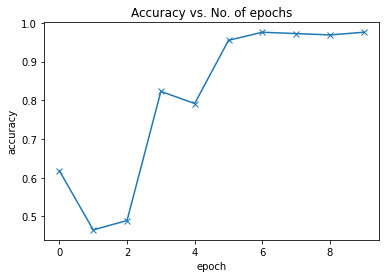

In [100]:
plot_accuracies(history)

In [101]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

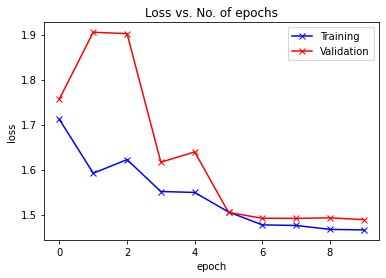

In [102]:
plot_losses(history)

In [111]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return labels_name[preds[0].item()]

Label: white_headed_capuchin , Predicted: white_headed_capuchin


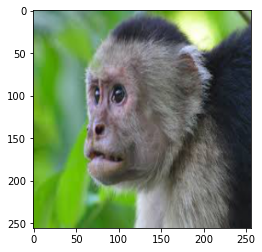

In [116]:
img, label = test_dataset[50]
plt.imshow(img.permute(1, 2, 0))
print('Label:', labels_name[label], ', Predicted:', predict_image(img, model))

Label: mantled_howler , Predicted: japanese_macaque


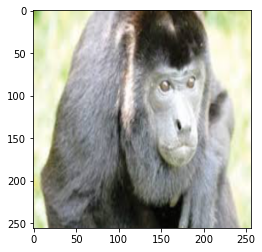

In [114]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', labels_name[label], ', Predicted:', predict_image(img, model))

Label: nilgiri_langur , Predicted: nilgiri_langur


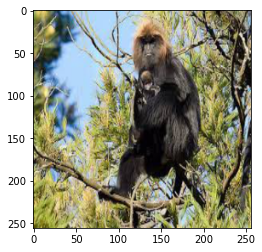

In [117]:
img, label = test_dataset[99]
plt.imshow(img.permute(1, 2, 0))
print('Label:', labels_name[label], ', Predicted:', predict_image(img, model))

Label: patas_monkey , Predicted: patas_monkey


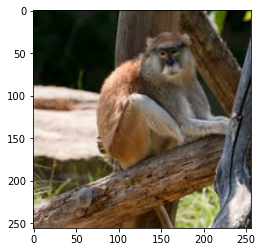

In [118]:
img, label = test_dataset[11]
plt.imshow(img.permute(1, 2, 0))
print('Label:', labels_name[label], ', Predicted:', predict_image(img, model))

test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

In [120]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.483994483947754, 'val_acc': 0.9704861044883728}

In [121]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

[jovian] Metrics logged.


In [122]:
torch.save(model.state_dict(), 'monkeycnn.pth')

In [123]:
model2 = to_device(MonkeyCnnModel2(), device)

In [124]:
model2.load_state_dict(torch.load('monkeycnn.pth'))

<All keys matched successfully>

In [125]:
evaluate(model2, val_loader)

{'val_loss': 1.4886225461959839, 'val_acc': 0.9756944179534912}

In [126]:
jovian.commit(project='Classification_of_Monkeys_Project_Zero_to_Gans')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/riyanahmad99/Classification_of_Monkeys_Project_Zero_to_Gans


<IPython.core.display.Javascript object>